# Try This Exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from empca import empca

Please find in the Canvas a file called "spec4000_corrected_weights".  This is a sample of spectra compiled by Ivezic to illustrate PCA.  The data does not come with errors, so I dummied up some weights.  Some of the spectra have fluxes less than zero, and the weights in those bins are set to zero.

The file is big, so you'll want to upload it into your "Temporary" directory on SciServer.  

Let's look at the form of the included data:

In [2]:
fn = '../../lectures/lecture13/spec4000_corrected_weights'
with open(fn, 'rb') as f:
    cv = pickle.load(f, encoding="latin1") 

In [3]:
# print(flux.shape)
# print(weights.shape)
# print(wavelengths.shape)
# print(labels.shape)
# print(index.shape)

There are four hundred spectra and 1000 wavelength bins.

These data are pretty crappy, and it is somewhat difficult to get anything sensible out of it.  It seems to work reasonably well if you limit your experiment to "stars" and "absorption galaxies".  These are identified by `index==1` and `index==2` in the index vector.

The fluxes are the observed fluxes, which have a wide range, e.g., depending on how far away the object is. So we should normalize the data.  I normalized by dividing by the integrated flux.  Other ways to normalize might be to normalize by the median flux in some wavelength range.  

### Part 1

Prepare the data.  Normalize the spectra, isolate the data with `index==1` or `index==2`, compute the weighted mean, and subtract the weighted mean.  You may also want to make  weighted mean spectra of just the stars and just the absorption galaxies to see what you're looking at.  Note that the spectra of galaxies is just the sum of spectra of stars, so the difference will be subtle. 

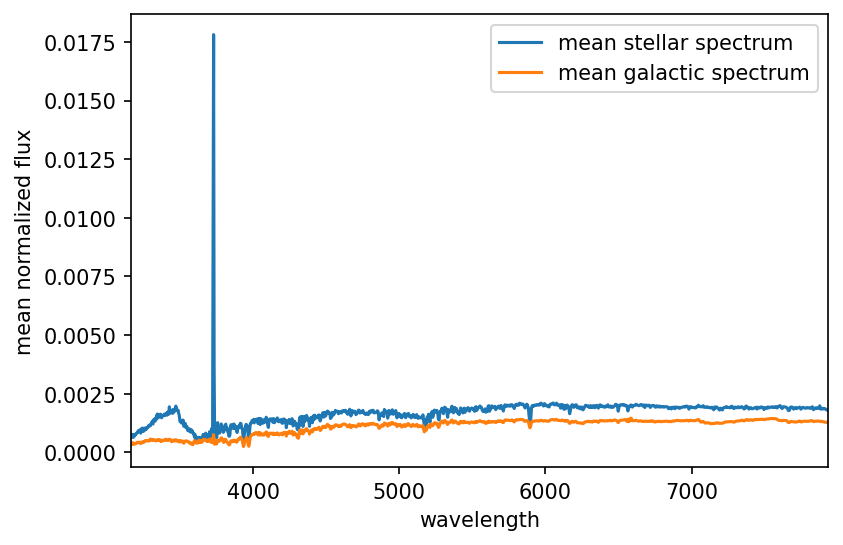

In [4]:
flux = cv[0]
weights = cv[1]
wavelengths = cv[2]
labels = cv[3]
index = cv[4]

# get stars and absorption galaxies
mask = (index == 1) + (index == 2)
index = index[mask]
flux = flux[mask]
weights = weights[mask]

# normalize
norm = flux.sum(axis=1)
norm_flux = (flux.T / norm).T
norm_weights = (weights.T / norm).T

# subtract weighted mean
mask_star = index == 1
mask_galaxy = index == 2

def GetWeightedMean(flux, weights):
    weight_sum = weights.sum(axis=0)
    mean = np.sum(flux * weights, axis=0) / weight_sum
    return mean

mean_star = GetWeightedMean(norm_flux[mask_star], weights[mask_star])
mean_galaxy = GetWeightedMean(norm_flux[mask_galaxy], weights[mask_galaxy])

norm_flux[mask_star] = norm_flux[mask_star] - mean_star
norm_flux[mask_galaxy] = norm_flux[mask_galaxy] - mean_galaxy

# visualize means
fig, ax = plt.subplots(dpi=150)

ax.plot(wavelengths, mean_star, c='tab:blue', label='mean stellar spectrum')
ax.plot(wavelengths, mean_galaxy, c='tab:orange', label='mean galactic spectrum')

ax.set_xlabel('wavelength')
ax.set_ylabel('mean normalized flux')
ax.set_xlim(wavelengths.min(), wavelengths.max())

ax.legend()

plt.show()

### Part 2

Run `empca` on the result.  You'll notice that the reported reduced $\chi^2$ is low.  That is due to the estimated variances.

How many eigenvectors do you think you need to keep?  Plot the eigenvectors you need to keep.

> I decided to keep 9 eigenvectors, as the explained variance seems to level off at low percentages around 5-9 eigenvectors.

In [5]:
nvec = 25
model = empca(norm_flux, weights=weights, nvec=nvec)

C:\Users\masamune\Dropbox\school\machine_learning\try_this\tt13\empca.py:254: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = N.linalg.lstsq(A, b)[0]


       iter        R2             rchi2
EMPCA  1/25       0.02494808      0.00001664
EMPCA  2/25     -12.43307235      0.00010287
EMPCA  3/25      -3.47192811      0.00004199
EMPCA  4/25      -0.06704647      0.00000841
EMPCA  5/25       0.70570715      0.00000209
EMPCA  6/25       0.88300237      0.00000055
EMPCA  7/25       0.86222786      0.00000073
EMPCA  8/25       0.85786509      0.00000091
EMPCA  9/25       0.84873594      0.00000110
EMPCA 10/25       0.82922023      0.00000128
EMPCA 11/25       0.83989374      0.00000100
EMPCA 12/25       0.89407384      0.00000047
EMPCA 13/25       0.91798652      0.00000027
EMPCA 14/25       0.91881842      0.00000025
EMPCA 15/25       0.92092302      0.00000023
EMPCA 16/25       0.92216379      0.00000022
EMPCA 17/25       0.92270695      0.00000021
EMPCA 18/25       0.92306805      0.00000021
EMPCA 19/25       0.92306479      0.00000021
EMPCA 20/25       0.92276138      0.00000021
EMPCA 21/25       0.92243995      0.00000022
EMPCA 22/25    

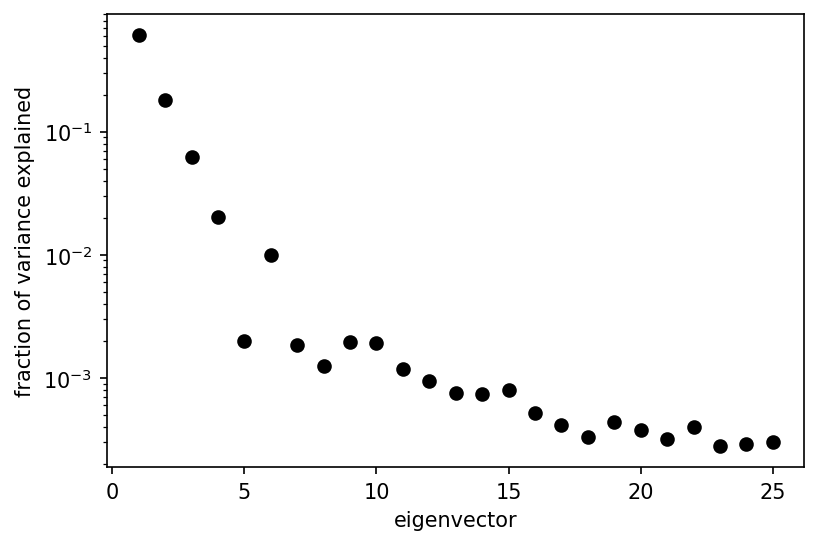

In [6]:
fractional = np.array([model.R2vec(i) for i in range(nvec)])
eig = np.arange(1, nvec + 1)

fig, ax = plt.subplots(dpi=150)

ax.plot(eig, fractional, 'o', c='k')

ax.set_xlabel('eigenvector')
ax.set_ylabel('fraction of variance explained')
ax.set_yscale('log')

plt.show()

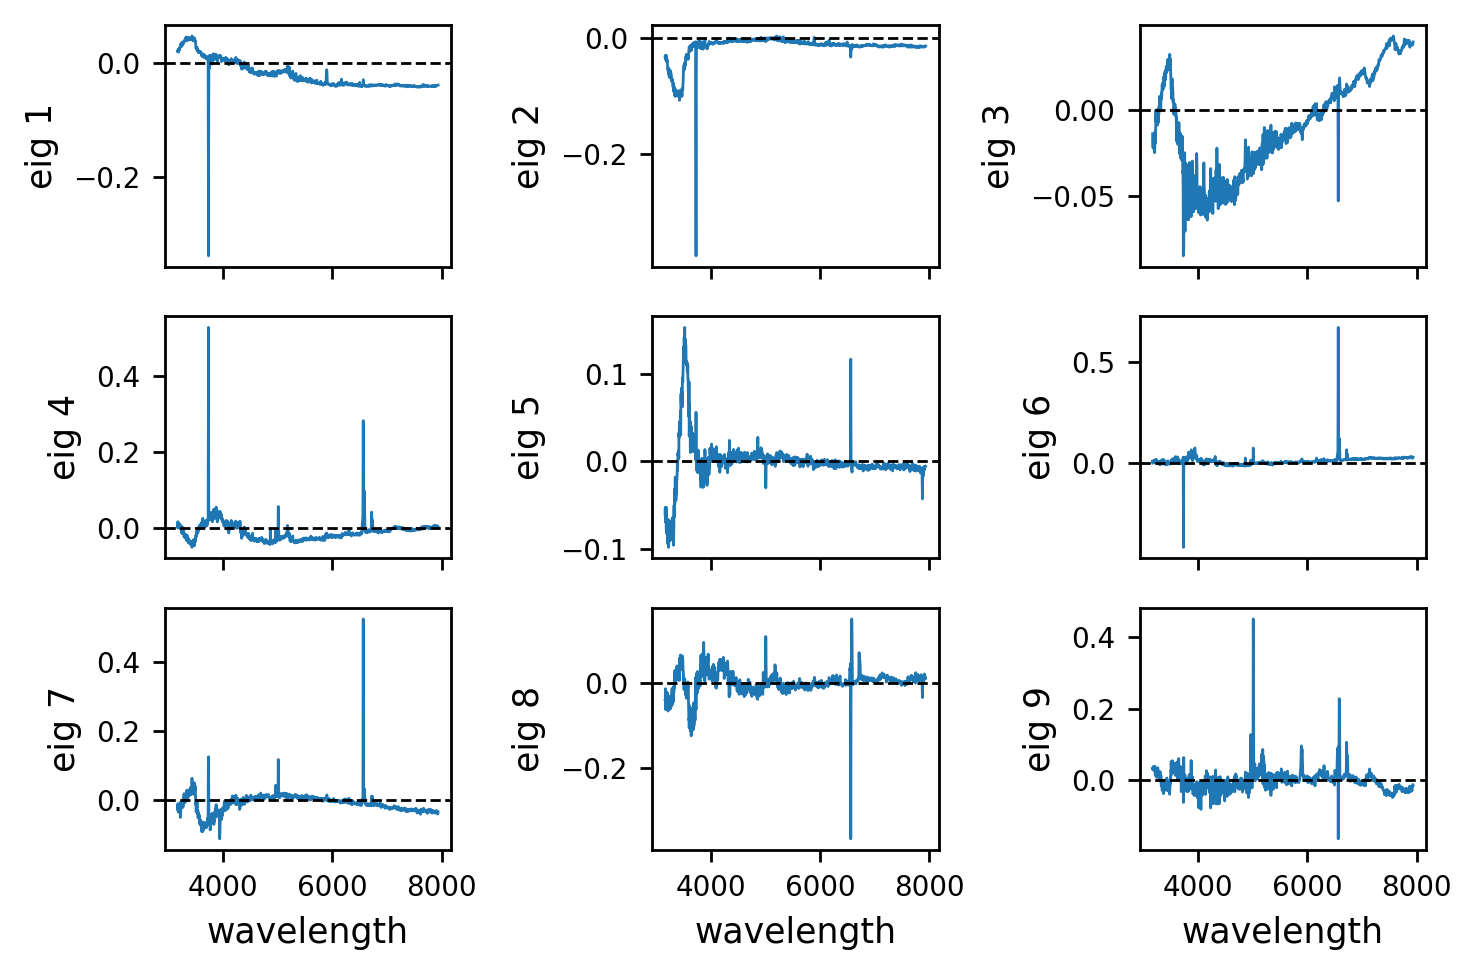

In [7]:
def plot_eig(axis, ind, model):
    axis.plot(wavelengths, model.eigvec[ind], lw=0.8,
              c='tab:blue', label=f'eigenvector {i + 1}')
    axis.tick_params('both', labelsize=8)
    axis.set_ylabel(f'eig {ind + 1}')
    axis.axhline(0., color='k', ls='--', lw=0.8)

fig, ax = plt.subplots(3, 3, sharex=True, dpi=250)

for i, _ax in enumerate(ax.ravel()):
    plot_eig(_ax, i, model)

[ax[2, i].set_xlabel('wavelength') for i in range(3)]

plt.tight_layout()
plt.show()

### Part 3

Pick one of your spectra, and check the reconstruction using the eigenvectors.  How good is it?  

> Below I reconstructed an example star spectrum using the previous 9 eigenvectors. The model here seems to fit fairly well above ~3600 angstroms, however below that the fit is quite poor.

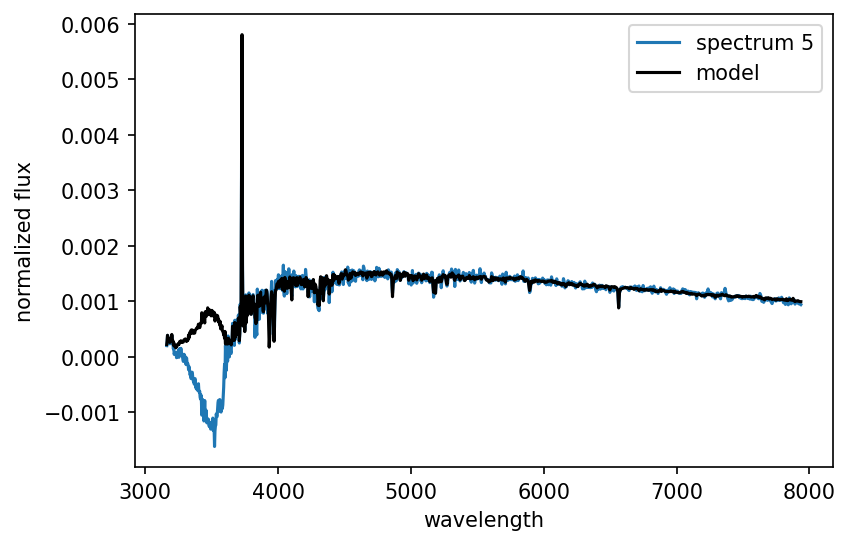

In [8]:
n_eig = 9
sample_ind = 5
mask = mask_star
mean = mean_star
sample_spec = norm_flux[mask][sample_ind] + mean
model_spec = (model.eigvec[:n_eig].T * model.coeff[mask][sample_ind, :n_eig]).T.sum(axis=0) + mean

fig, ax = plt.subplots(dpi=150)

ax.plot(wavelengths, sample_spec, c='tab:blue', label=f'spectrum {sample_ind}')
ax.plot(wavelengths, model_spec, c='k', label='model')

ax.set_xlabel('wavelength')
ax.set_ylabel('normalized flux')

ax.legend()

plt.show()

### Part 4 

Plot the eigenvector coeffients.  Using the known identifications, plot the "stars" using a different color than the "galaxies".  Do the stars fall in a different region of parameter space than the galaxies?

> Below I plot the latter 8 eigenvector coefficients against the first. Separating stellar spectra from galactic spectra, we immediately notice that the galaxy spectra are clustered in a way that the stars' aren't, and it seems then that the stars do indeed fall in a different region of parameter space.

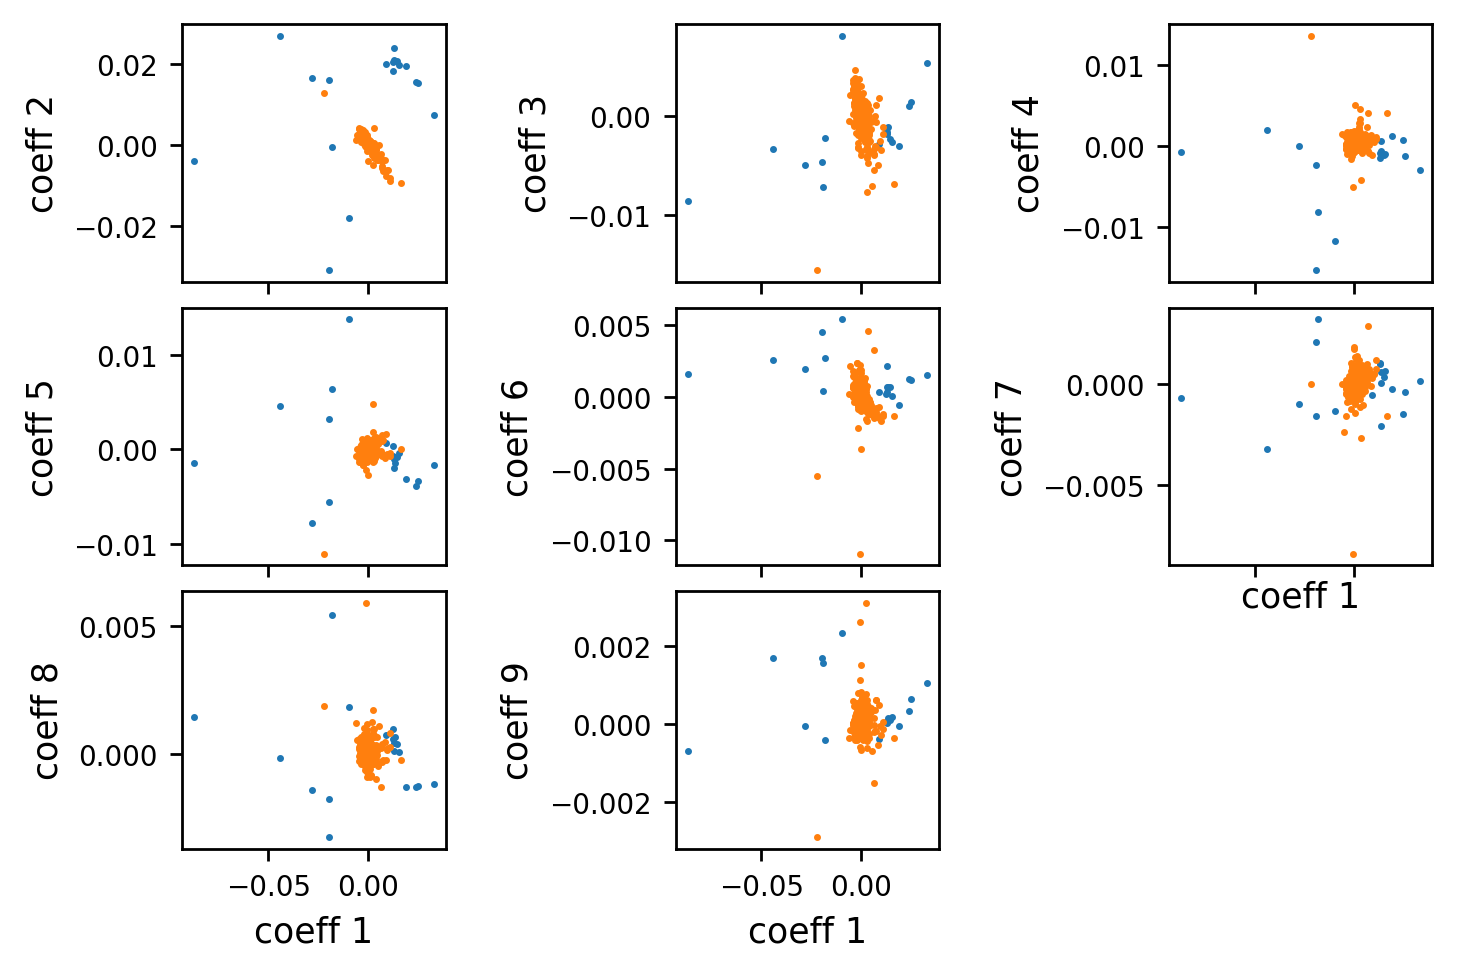

In [9]:
def plot_coeff(axis, ind, model, target):
    if target == 'star':
        mask = mask_star
        col = 'tab:blue'
    elif target == 'galaxy':
        mask = mask_galaxy
        col = 'tab:orange'

    axis.plot(model.coeff[mask][:, 0], model.coeff[mask][:, ind], 'o', ms=1, c=col, label=target)
    axis.tick_params('both', labelsize=8)
    axis.set_ylabel(f'coeff {ind + 1}')

fig, ax = plt.subplots(3, 3, sharex=True, dpi=250)

for i, _ax in enumerate(ax.ravel()[:-1]):
    plot_coeff(_ax, i + 1, model, target='star')
    plot_coeff(_ax, i + 1, model, target='galaxy')

[ax[2, i].set_xlabel('coeff 1') for i in range(2)]
ax[1, 2].set_xlabel('coeff 1')
ax[2, 2].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

plt.show()